## Nested Logit

In [1]:
import pandas as pd
import pymc as pm
import patsy
import numpy as np
import pytensor.tensor as pt
import arviz as az
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../..')

%reload_ext autoreload
from pymc_marketing.customer_choice.nested_logit import NestedLogit

In [2]:
df = pd.read_csv('../../../../data/choice_wide_heating.csv')
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


In [3]:
alternatives = ['gc', 'ec', 'gr', 'er', 'hp']

coords = {
    "alts": alternatives,
    "alts_probs": alternatives[:-1],
    "covariates": ['ic', 'oc'],
    "fixed_covariates": ['income'],
    'nests': ['central', 'room'],
    'room_alts': ['gr', 'er', 'hp'],
    'central_alts': ['gc', 'ec'],
    "obs": range(len(df)),
}


# Mode mapping
mode_mapping = {'gc': 0, 'ec': 1, 'gr': 2, 'er': 3, 'hp': 4}
df['mode_encoded'] = df['depvar'].map(mode_mapping)
y = df['mode_encoded'].values

nest_indices = {'central': [0, 1],
               'room': [2, 3, 4], 
               #'room_hp': [4],
               #'room_r': [2, 3]
               }

lambda_lkup = {'room': 0, 'central': 1}

coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'covariates': ['ic', 'oc'],
 'fixed_covariates': ['income'],
 'nests': ['central', 'room'],
 'room_alts': ['gr', 'er', 'hp'],
 'central_alts': ['gc', 'ec'],
 'obs': range(0, 900)}

In [4]:
utility_formulas = ['gc ~ ic_gc + oc_gc | income ', 
                    'ec ~ ic_ec + oc_ec | income ',
                    'gr ~ ic_gr + oc_gr | income ', 
                    'er ~ ic_er + oc_er | income ', 
                    'hp ~ ic_hp + oc_hp | income ']

nstL = NestedLogit(df, utility_formulas, 'depvar', covariates=['ic', 'oc'], nesting_structure=nest_indices)
nstL

In [5]:
X, F, y = nstL.preprocess_model_data(df, utility_formulas)
print(X.shape)
F.shape

(900, 5, 2)


In [ ]:
N = df.shape[0]

def make_exp_nest(U, w_nest, lambdas_nests, nest, parent_lambda=None):
    y_nest = U[:, nest_indices[nest]]
    if len(nest_indices[nest]) > 1:
        max_y_nest = pm.math.max(y_nest, axis=0)
        P_y_given_nest = pm.Deterministic(
            f"p_y_given_{nest}",
            pm.math.softmax(y_nest / lambdas_nests[lambda_lkup[nest]], axis=1),
            dims=("obs", f"{nest}_alts"),
        )
    else:
        max_y_nest = pm.math.max(y_nest)
        ones = pm.math.ones((N, 1))
        P_y_given_nest = pm.Deterministic(f"p_y_given_{nest}", ones)
    if parent_lambda is None:
        lambda_ = lambdas_nests[lambda_lkup[nest]]
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambda_)
        )
        W_nest = w_nest + I_nest * lambda_
    else:
        l1 = lambdas_nests[lambda_lkup[nest]]
        l2 = lambdas_nests[lambda_lkup[parent_lambda]]
        lambdas_ = l1 * l2
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambdas_)
        )
        W_nest = w_nest + I_nest * (lambdas_)

    exp_W_nest = pm.math.exp(W_nest)
    return exp_W_nest, P_y_given_nest

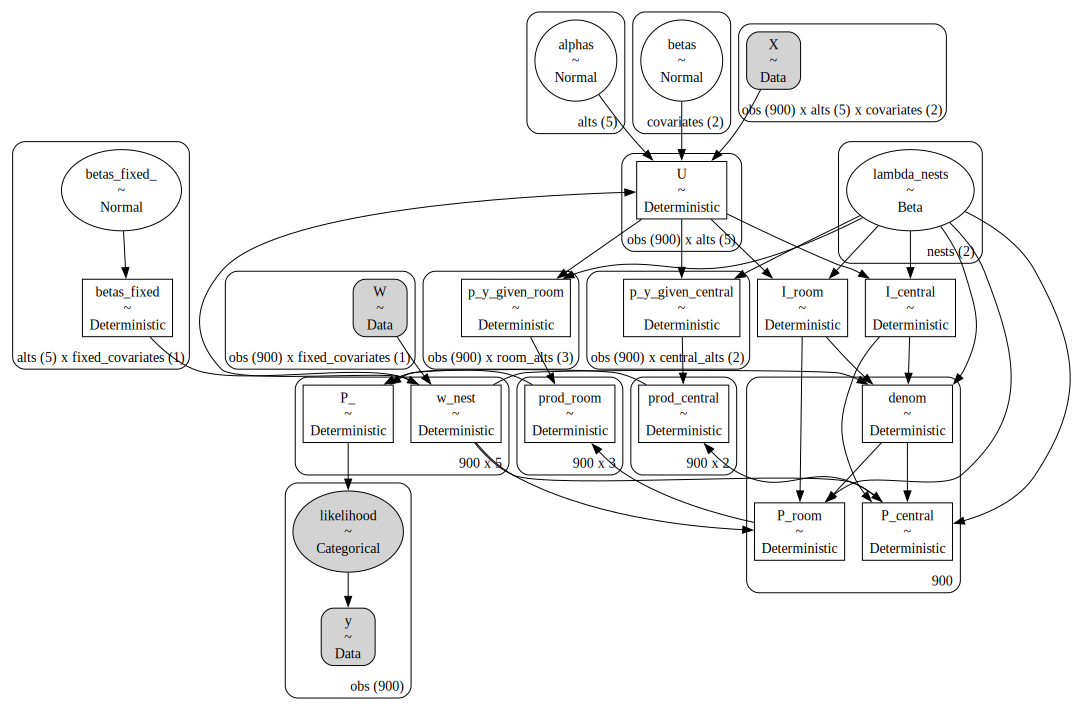

In [102]:
def make_model(X, y, W, N=900):
    with pm.Model(coords=coords) as model:
        alphas = pm.Normal('alphas', 0, 1, dims='alts')
        betas = pm.Normal('betas', 0, 1, dims=('covariates'))
        lambdas_nests = pm.Beta('lambda_nests', 2, 2, dims='nests')
        
        if W is None:
            w_nest = pm.math.zeros((len(coords['obs']), 
                                    len(coords['alts'])))
        else: 
            W_data = pm.Data('W', W, dims=('obs', 'fixed_covariates'))
            betas_fixed_ = pm.Normal('betas_fixed_', 0, 1, dims=('alts', 'fixed_covariates'))
            betas_fixed = pm.Deterministic('betas_fixed', pt.set_subtensor(betas_fixed_[-1, :], 0), 
                dims=('alts','fixed_covariates'))
            w_nest = pm.Deterministic('w_nest', pm.math.dot(W_data, betas_fixed.T))
        X_data = pm.Data('X', X,  dims=('obs', 'alts', 'covariates'))
        y_data = pm.Data('y', y, dims='obs')

        # Compute utility as a dot product
        alphas = pt.set_subtensor(alphas[-1], 0)
        u = alphas + pm.math.dot(X_data, betas)
        U = pm.Deterministic('U', w_nest + u, dims=('obs', 'alts'))
        
        ## Top Level
        conditional_probs = {}
        for n in nest_indices.keys():
            exp_W_nest, P_y_given_nest = make_exp_nest(U, w_nest, 
                lambdas_nests, n)
            if W is None:
                conditional_probs[n] = {'exp': exp_W_nest, 'P_y_given': P_y_given_nest}
            else: 
                exp_W_nest = pm.math.sum(exp_W_nest, axis=1)
                conditional_probs[n] = {'exp': exp_W_nest, 'P_y_given': P_y_given_nest}
      
        denom = pm.Deterministic('denom', pm.math.sum([conditional_probs[n]['exp'] for n in nest_indices.keys()], axis=0))
        nest_probs = {}
        for n in nest_indices.keys():
            P_nest = pm.Deterministic(f'P_{n}', (conditional_probs[n]['exp'] / denom))
            nest_probs[n] = P_nest
        
        ## Construct Paths Bottom -> Up
        path_prods = []
        for n in nest_indices.keys():
            P_nest = nest_probs[n]
            P_y_given_nest = conditional_probs[n]['P_y_given']
            prod = pm.Deterministic(f'prod_{n}', (P_nest[:, pt.newaxis]*P_y_given_nest))
            path_prods.append(prod)
        P_ = pm.Deterministic('P_',  pm.math.concatenate(path_prods, axis=1))
        choice_obs = pm.Categorical("likelihood", p=P_, observed=y_data, dims="obs")

    return model


model = make_model(X, y, W=F)
pm.model_to_graphviz(model)

In [107]:
with model: 
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(
        target_accept=.97,
        nuts_sampler='blackjax',
        idata_kwargs={"log_likelihood": True}, 
        random_seed=101))
    

Sampling: [alphas, betas, betas_fixed_, lambda_nests, likelihood]


Running window adaptation


In [95]:
az.summary(idata, var_names=['betas', 'alphas', 'betas_fixed'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.001,0.001,-0.002,-0.000,0.000,0.000,3773.0,2905.0,1.0
betas[oc],-0.006,0.001,-0.008,-0.003,0.000,0.000,2957.0,2676.0,1.0
alphas[gc],0.078,0.761,-1.364,1.510,0.016,0.014,2439.0,1915.0,1.0
alphas[ec],-0.037,0.757,-1.537,1.307,0.015,0.014,2605.0,2284.0,1.0
alphas[gr],0.478,0.317,-0.106,1.078,0.008,0.005,1603.0,1997.0,1.0
alphas[er],1.562,0.431,0.744,2.350,0.011,0.006,1572.0,2458.0,1.0
alphas[hp],-0.015,1.012,-1.761,2.013,0.016,0.016,4132.0,2995.0,1.0
"betas_fixed[gc, income]",0.040,0.519,-0.925,1.107,0.012,0.011,1980.0,2096.0,1.0
"betas_fixed[ec, income]",0.043,0.520,-0.973,1.064,0.012,0.011,1969.0,2008.0,1.0
"betas_fixed[gr, income]",-0.089,0.061,-0.201,0.025,0.002,0.001,1502.0,1962.0,1.0


In [ ]:
az.summary(idata, var_names=['betas', 'alphas', 'betas_fixed'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],0.000,0.001,-0.001,0.001,0.000,0.000,3588.0,2690.0,1.00
betas[oc],-0.000,0.001,-0.002,0.002,0.000,0.000,3886.0,2774.0,1.00
alphas[gc],0.864,0.747,-0.548,2.237,0.015,0.012,2545.0,2322.0,1.00
alphas[ec],-0.850,0.754,-2.195,0.582,0.015,0.012,2607.0,2360.0,1.00
alphas[gr],0.914,0.419,0.170,1.728,0.008,0.008,2531.0,2609.0,1.00
alphas[er],0.454,0.305,-0.057,1.089,0.006,0.005,2657.0,2309.0,1.00
alphas[hp],0.001,1.034,-2.038,1.867,0.015,0.020,4803.0,2490.0,1.00
"betas_fixed[gc, income]",-0.011,0.610,-1.225,1.179,0.022,0.015,786.0,1192.0,1.01
"betas_fixed[ec, income]",-0.022,0.611,-1.172,1.229,0.022,0.015,783.0,1174.0,1.01
"betas_fixed[gr, income]",-0.087,0.057,-0.189,0.028,0.001,0.001,2928.0,2391.0,1.00


In [108]:
az.summary(idata, var_names=['betas', 'alphas', 'betas_fixed'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.001,0.001,-0.003,-0.000,0.000,0.000,3137.0,3164.0,1.0
betas[oc],-0.005,0.001,-0.008,-0.003,0.000,0.000,2358.0,2894.0,1.0
alphas[gc],0.074,0.732,-1.265,1.465,0.014,0.011,2670.0,2903.0,1.0
alphas[ec],-0.059,0.728,-1.408,1.299,0.014,0.012,2587.0,2469.0,1.0
alphas[gr],0.482,0.314,-0.081,1.099,0.008,0.006,1648.0,1961.0,1.0
alphas[er],1.554,0.429,0.741,2.351,0.011,0.006,1654.0,2393.0,1.0
alphas[hp],-0.010,0.996,-1.877,1.869,0.016,0.017,3770.0,2356.0,1.0
"betas_fixed[gc, income]",0.060,0.516,-0.921,1.117,0.014,0.014,1327.0,1406.0,1.0
"betas_fixed[ec, income]",0.065,0.518,-0.870,1.165,0.015,0.014,1330.0,1419.0,1.0
"betas_fixed[gr, income]",-0.089,0.060,-0.207,0.018,0.002,0.001,1510.0,1891.0,1.0


array([<Axes: title={'center': 'betas\nic'}>,
       <Axes: title={'center': 'betas\noc'}>], dtype=object)

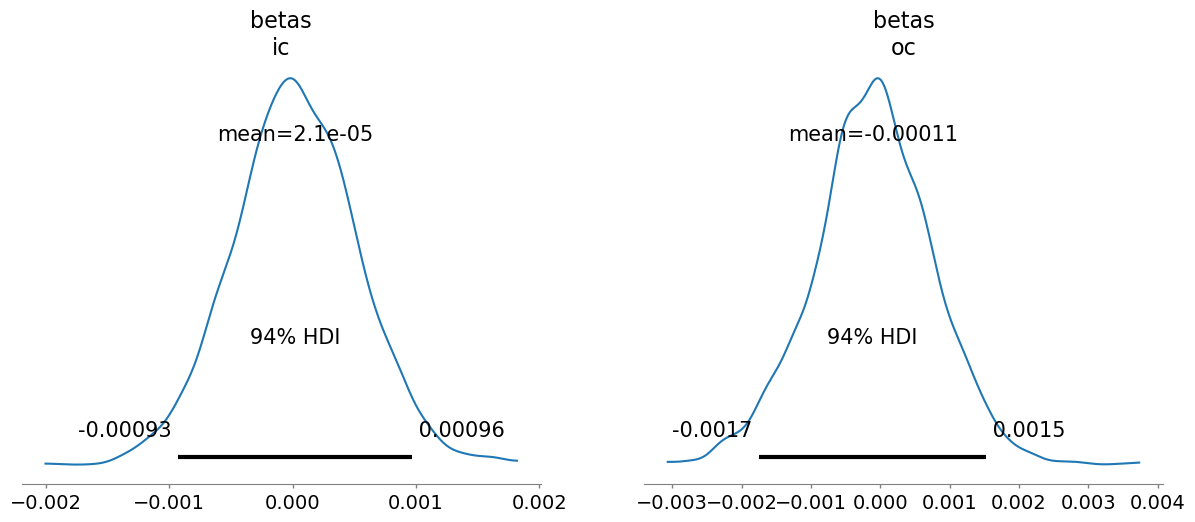

In [106]:
az.plot_posterior(idata, var_names=['betas'], )

In [84]:
pd.DataFrame(idata['prior']['p_y_given_room'].mean(dim=('chain', 'draw')).values)

,0,1,2
0,0.330929,0.374961,0.294110
1,0.339847,0.356696,0.303457
2,0.338646,0.303306,0.358048
3,0.308094,0.316159,0.375747
4,0.459434,0.475728,0.064838
...,...,...,...
895,0.369030,0.415916,0.215053
896,0.344912,0.406749,0.248339
897,0.511883,0.458093,0.030024
898,0.361228,0.347411,0.291361


In [71]:
pd.DataFrame(idata['prior']['p_y_given_central'].mean(dim=('chain', 'draw')).values)

,0,1
0,0.496436,0.503564
1,0.496006,0.503994
2,0.504251,0.495749
3,0.475929,0.524071
4,0.501919,0.498081
...,...,...
895,0.496000,0.504000
896,0.498885,0.501115
897,0.495833,0.504167
898,0.488796,0.511204


In [86]:
w_nest = pd.DataFrame(idata['prior']['w_nest'].mean(dim=('chain', 'draw')).values)
w_nest 

a = np.exp(w_nest + (idata['prior']['I_room'][0, 0]*idata['prior']['lambda_nests'][0, 0, 0]).item())

b = np.exp(w_nest + (idata['prior']['I_room'][0, 0]*idata['prior']['lambda_nests'][0, 0, 0]).item())

np.sum([np.sum(a, axis=1) , np.sum(a, axis=1)], axis=0)
a



,0,1,2,3,4
0,3.057192,3.342217,2.167945,1.977721,3.606565
1,3.205005,3.415703,2.507288,2.348097,3.606565
2,3.281571,3.453050,2.696386,2.558536,3.606565
3,3.440232,3.528973,3.118444,3.037685,3.606565
4,3.440232,3.528973,3.118444,3.037685,3.606565
...,...,...,...,...,...
895,3.130226,3.378761,2.331451,2.154966,3.606565
896,3.057192,3.342217,2.167945,1.977721,3.606565
897,3.205005,3.415703,2.507288,2.348097,3.606565
898,3.205005,3.415703,2.507288,2.348097,3.606565


In [88]:
pd.DataFrame(idata['prior']['denom'].mean(dim=('chain', 'draw')).values).round(2)

,0
0,32517853.93
1,106614.70
2,7269.99
3,83.07
4,83.07
...,...
895,1784036.04
896,32517853.93
897,106614.70
898,106614.70


In [61]:
pd.DataFrame(idata['prior']['P_room'].mean(dim=('chain', 'draw')).values)

,0
0,0.001885
1,0.000336
2,0.000215
3,0.000153
4,0.000153
...,...
895,0.000678
896,0.001885
897,0.000336
898,0.000336


In [90]:
pd.DataFrame(idata['prior']['P_'].mean(dim=('chain', 'draw')).values).sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
895    1.0
896    1.0
897    1.0
898    1.0
899    1.0
Length: 900, dtype: float64

In [9]:
model.debug()

point={'alphas': array([0., 0., 0., 0., 0.]), 'betas': array([0., 0.]), 'lambda_nests_logodds__': array([0., 0.]), 'betas_fixed_': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])}

The variable likelihood has the following parameters:
0: Join [id A] <Matrix(float64, shape=(?, ?))> 'P_'
 ├─ 1 [id B] <Scalar(int8, shape=())>
 ├─ Mul [id C] <Matrix(float64, shape=(?, ?))> 'prod_central'
 │  ├─ Transpose{axes=[1, 0]} [id D] <Matrix(float64, shape=(?, 2))>
 │  │  └─ AdvancedSubtensor1 [id E] <Matrix(float64, shape=(2, ?))>
 │  │     ├─ True_div [id F] <Matrix(float64, shape=(?, ?))>
 │  │     │  ├─ Transpose{axes=[1, 0]} [id G] <Matrix(float64, shape=(?, ?))>
 │  │     │  │  └─ Exp [id H] <Matrix(float64, shape=(?, ?))>
 │  │     │  │     └─ Add [id I] <Matrix(float64, shape=(?, ?))>
 │  │     │  │        ├─ Dot22 [id J] <Matrix(float64, shape=(?, ?))> 'w_nest'
 │  │     │  │        │  ├─ W [id K] <Matrix(float64, shape=(?, ?))>
 │  │     │  │        │  └─ Transpose{axes=[

In [224]:
idata['prior']['P_central'].mean(dim=('chain', 'draw', 'P_central_dim_0'))
idata['prior']

<xarray.Dataset> Size: 144MB
Dimensions:              (chain: 1, draw: 500, prod_room_dim_0: 900,
                          prod_room_dim_1: 3, alts: 5, P__dim_0: 900,
                          P__dim_1: 5, concentration_dim_0: 5,
                          prod_central_dim_0: 900, prod_central_dim_1: 2,
                          obs: 900, central_alts: 2, w_nest_dim_0: 900,
                          w_nest_dim_1: 5, P_central_dim_0: 900,
                          P_central_dim_1: 5, nests: 2, covariates: 2,
                          P_room_dim_0: 900, P_room_dim_1: 5, room_alts: 3,
                          fixed_covariates: 1)
Coordinates: (12/22)
  * chain                (chain) int64 8B 0
  * draw                 (draw) int64 4kB 0 1 2 3 4 5 ... 495 496 497 498 499
  * prod_room_dim_0      (prod_room_dim_0) int64 7kB 0 1 2 3 ... 896 897 898 899
  * prod_room_dim_1      (prod_room_dim_1) int64 24B 0 1 2
  * alts                 (alts) <U2 40B 'gc' 'ec' 'gr' 'er' 'hp'
  * P__dim_0             (P__dim_0) int64 7kB 0 1 2 3 4 ... 895 896 897 898 899
    ...                   ...
  * nests                (nests) <U7 56B 'central' 'room'
  * covariates           (covariates) <U2 16B 'ic' 'oc'
  * P_room_dim_0         (P_room_dim_0) int64 7kB 0 1 2 3 4 ... 896 897 898 899
  * P_room_dim_1         (P_room_dim_1) int64 40B 0 1 2 3 4
  * room_alts            (room_alts) <U2 24B 'gr' 'er' 'hp'
  * fixed_covariates     (fixed_covariates) <U6 24B 'income'
Data variables: (12/18)
    I_central            (chain, draw) float64 4kB 0.6933 1.067 ... 0.7467
    prod_room            (chain, draw, prod_room_dim_0, prod_room_dim_1) float64 11MB ...
    alphas               (chain, draw, alts) float64 20kB -0.4891 ... -0.7653
    P_                   (chain, draw, P__dim_0, P__dim_1) float64 18MB 0.002...
    concentration        (chain, draw, concentration_dim_0) float64 20kB 0.00...
    I_room               (chain, draw) float64 4kB 1.099 1.099 ... 1.101 1.393
    ...                   ...
    p_                   (chain, draw, obs, alts) float64 18MB 1.0 0.0 ... 0.0
    betas                (chain, draw, covariates) float64 8kB -0.5768 ... 0....
    P_room               (chain, draw, P_room_dim_0, P_room_dim_1) float64 18MB ...
    p_y_given_room       (chain, draw, obs, room_alts) float64 11MB 1.0 ... 3...
    betas_fixed          (chain, draw, alts, fixed_covariates) float64 20kB 1...
    betas_fixed_         (chain, draw, alts, fixed_covariates) float64 20kB 1...
Attributes:
    created_at:                 2025-04-22T06:39:55.085753+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0

In [207]:
az.summary(idata, var_names=['alphas', 'betas', 'betas_fixed'])

#az.summary(idata, var_names=['alphas', 'betas'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],-0.692,0.741,-2.028,0.709,0.014,0.013,2836.0,2684.0,1.0
alphas[ec],0.675,0.747,-0.747,2.035,0.014,0.012,2732.0,2638.0,1.0
alphas[gr],0.177,0.198,-0.185,0.555,0.003,0.003,3198.0,2754.0,1.0
alphas[er],1.790,0.316,1.203,2.370,0.005,0.005,3395.0,2585.0,1.0
alphas[hp],0.014,1.006,-1.927,1.764,0.014,0.018,4923.0,2743.0,1.0
betas[ic],-0.002,0.001,-0.003,-0.000,0.000,0.000,4690.0,3603.0,1.0
betas[oc],-0.006,0.001,-0.009,-0.004,0.000,0.000,3747.0,2741.0,1.0
"betas_fixed[gc, income]",0.275,0.015,0.248,0.303,0.000,0.000,2886.0,2637.0,1.0
"betas_fixed[ec, income]",-0.085,0.026,-0.134,-0.036,0.000,0.000,3362.0,3007.0,1.0
"betas_fixed[gr, income]",-0.014,0.022,-0.059,0.025,0.000,0.000,2855.0,2756.0,1.0


<Axes: >

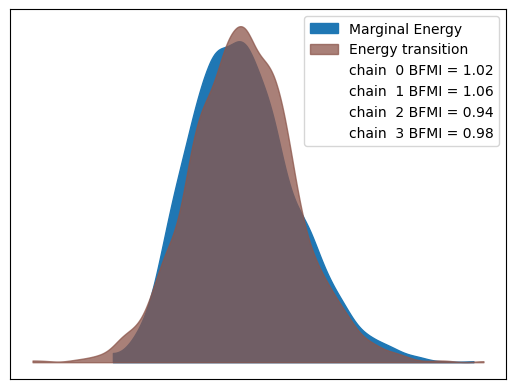

In [208]:
az.plot_energy(idata)

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


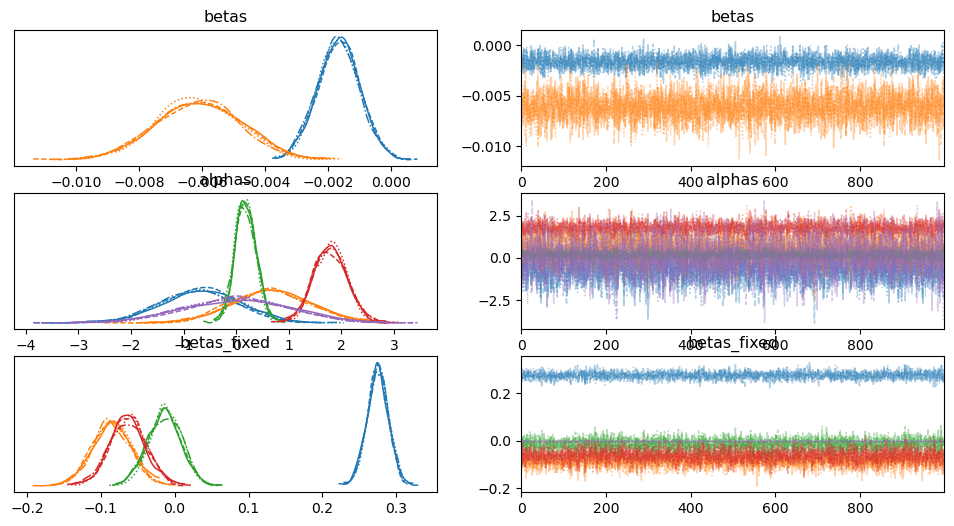

In [ ]:
az.plot_trace(idata, var_names=['betas', 'alphas', 'betas_fixed']);

## 2 Level Nesting

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


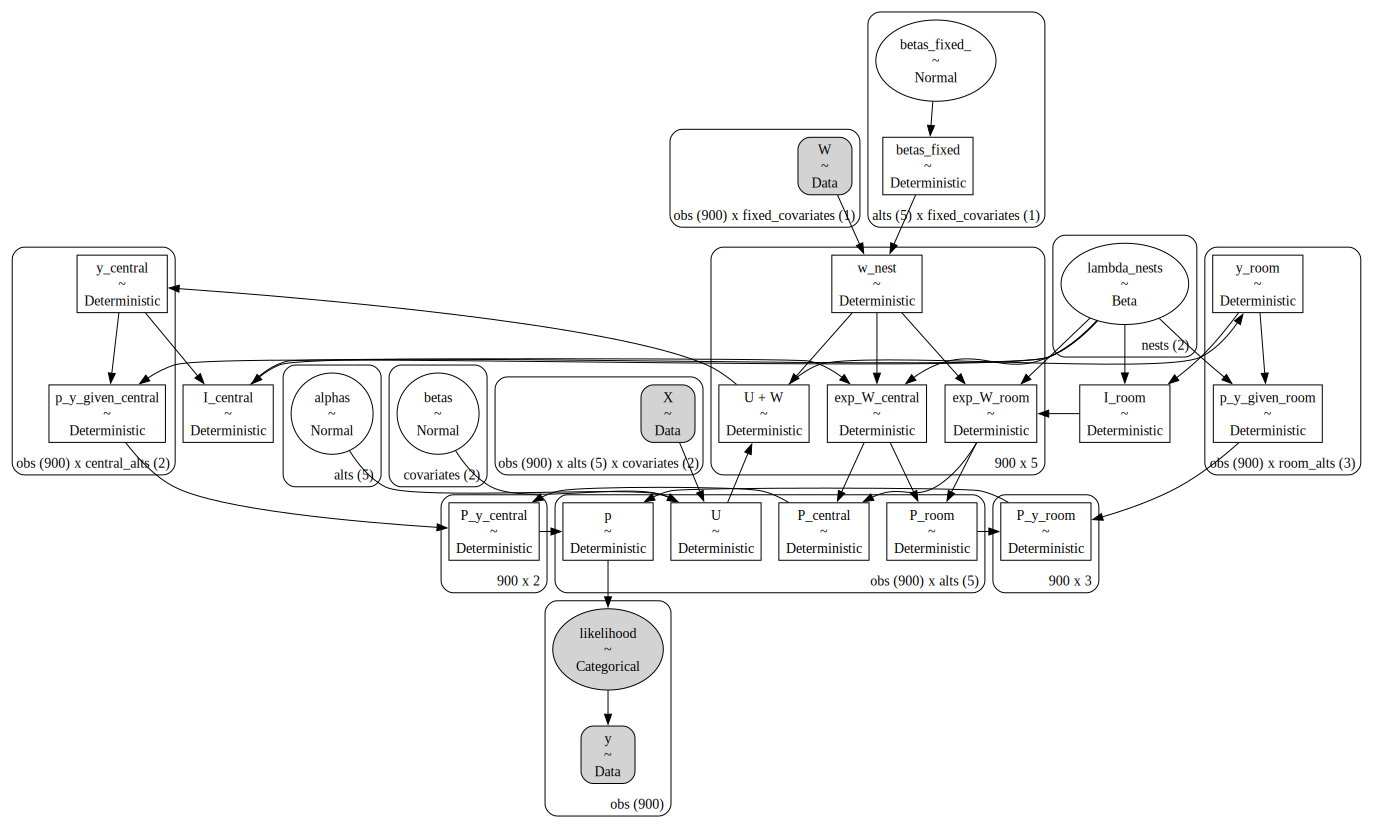

In [249]:
def make_nested_logit(X, y, coords, nest_indices, N, X_fixed=None):

    with pm.Model(coords=coords) as nested_model:
        alphas = pm.Normal('alphas', 0, 5, dims='alts')
        betas = pm.Normal('betas', 0, 1, dims=('covariates'))
        lambdas_nests = pm.Beta('lambda_nests', 2, 2, dims='nests')

        ## Nest Fixed values like income
        if X_fixed is None: 
            W = pm.math.zeros(N)
        else: 
            W_data = pm.Data('W', X_fixed, dims=('obs', 'fixed_covariates'))
            betas_fixed_ = pm.Normal('betas_fixed_', 0, 1, dims=('alts', 'fixed_covariates'))
            betas_fixed = pm.Deterministic('betas_fixed', pt.set_subtensor(betas_fixed_[-1, :], 0), 
                dims=('alts','fixed_covariates'))
            W = pm.Deterministic('w_nest', pm.math.dot(W_data, betas_fixed.T))

        X = pm.MutableData('X', X, dims=('obs', 'alts', 'covariates'))
        y = pm.MutableData('y', y, dims='obs')

        alphas = pt.set_subtensor(alphas[-1], 0)
        U = pm.Deterministic('U', 
            (alphas + pm.math.dot(X, betas)), 
            dims=('obs', 'alts'))

        U = pm.Deterministic('U + W', W + U)

        
        ## Create Nest Specific Probabilities
        nest_probabilities = []
        mprob_nest = {}
        for i, n in enumerate(nest_indices.keys()) :
            u = U[:, nest_indices[f'{n}']]
            y_nest = pm.Deterministic(f'y_{n}', u, 
                dims=('obs', f'{n}_alts'))
            if len(nest_indices[f'{n}']) > 1:
                max_y_nest = pm.math.max(y_nest, axis=0)
                s = pm.math.softmax(y_nest / lambdas_nests[i], axis=1)
                P_y_given_nest = pm.Deterministic(f'p_y_given_{n}', s, 
                    dims = ('obs', f'{n}_alts')) 
            else: 
                max_y_nest = pm.math.max(y_nest)
                ones = pm.math.ones((N, 1))
                P_y_given_nest = pm.Deterministic(f'p_y_given_{n}', ones)
            lsexp = pm.math.logsumexp((y_nest - max_y_nest)/lambdas_nests[i])
            I_nest = pm.Deterministic(f'I_{n}', lsexp)

            W_nest = W + I_nest*lambdas_nests[i]
            exp_W_nest = pm.Deterministic(f'exp_W_{n}', pm.math.exp(W_nest))
            nest_probabilities.append(exp_W_nest)
            mprob_nest[n] = P_y_given_nest

        ## Define Conditional Probability
        final_stack = []
        for n, np in zip(nest_indices.keys(), nest_probabilities): 
            P_nest =  pm.Deterministic(f'P_{n}', 
                (np / pm.math.sum(nest_probabilities, axis=0)), 
                dims=('obs', 'alts'))
            prod = (mprob_nest[n]*P_nest[:, nest_indices[n]])
            P_y_nest = pm.Deterministic(f'P_y_{n}', prod)
            final_stack.append(P_y_nest)

        # Stack into probability matrix
        final_stack = pm.math.concatenate(final_stack, axis=1)
        p_ = pm.Deterministic('p', final_stack, dims=('obs', 'alts'))
        
        choice_obs = pm.Categorical("likelihood", p=p_, observed=y, dims="obs")

    return nested_model

nested_model = make_nested_logit(X, y, coords, nest_indices, N, F)
pm.model_to_graphviz(nested_model)


In [251]:
with nested_model: 
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(
        target_accept=.97,
        nuts_sampler='numpyro',
        idata_kwargs={"log_likelihood": True}, 
        random_seed=101))

Sampling: [alphas, betas, betas_fixed_, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [253]:
az.summary(idata, var_names=['betas', 'alphas', 'betas_fixed'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.001,0.001,-0.003,-0.000,0.000,0.000,3413.0,2734.0,1.0
betas[oc],-0.006,0.002,-0.009,-0.004,0.000,0.000,3168.0,2973.0,1.0
alphas[gc],0.001,3.539,-6.996,6.227,0.073,0.063,2375.0,2378.0,1.0
alphas[ec],0.019,3.541,-6.978,6.199,0.072,0.063,2417.0,2293.0,1.0
alphas[gr],0.651,0.376,0.000,1.402,0.009,0.006,1811.0,2080.0,1.0
alphas[er],1.986,0.526,1.014,2.993,0.013,0.009,1720.0,2115.0,1.0
alphas[hp],-0.148,4.977,-9.618,9.244,0.080,0.087,3907.0,2440.0,1.0
"betas_fixed[gc, income]",0.034,0.483,-0.935,0.938,0.012,0.012,1591.0,1891.0,1.0
"betas_fixed[ec, income]",0.041,0.482,-0.894,0.968,0.012,0.012,1621.0,2007.0,1.0
"betas_fixed[gr, income]",-0.127,0.072,-0.256,0.011,0.002,0.001,1666.0,2122.0,1.0
